In [55]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.index_tricks import nd_grid


def sigmoid( x ):
    """ Sigmoid function.
    This function accepts any shape of np.ndarray object as input and perform sigmoid operation.
    """
    return 1 / ( 1 + np.exp( -x ) )


def der_sigmoid( y ):
    """ First derivative of Sigmoid function.
    The input to this function should be the value that output from sigmoid function.
    """
    return y * ( 1 - y )


class GenData:

    @staticmethod
    def _gen_linear( n=100 ):
        """ Data generation (Linear)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data = np.random.uniform( 0, 1, ( n, 2 ) )

        inputs = []
        labels = []

        for point in data:
            inputs.append( [ point[ 0 ], point[ 1 ] ] )

            if point[ 0 ] > point[ 1 ]:
                labels.append( 0 )
            else:
                labels.append( 1 )

        return np.array( inputs ), np.array( labels ).reshape( ( -1, 1 ) )

    @staticmethod
    def _gen_xor( n=100 ):
        """ Data generation (XOR)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data_x = np.linspace( 0, 1, n // 2 )

        inputs = []
        labels = []

        for x in data_x:
            inputs.append( [ x, x ] )
            labels.append( 0 )

            if x == 1 - x:
                continue

            inputs.append( [ x, 1 - x ] )
            labels.append( 1 )

        return np.array( inputs ), np.array( labels ).reshape( ( -1, 1 ) )

    @staticmethod
    def fetch_data( mode, n ):
        """ Data gather interface

        Args:
            mode (str): 'Linear' or 'XOR', indicate which generator is used.
            n (int):    the number of data points generated in total.
        """
        assert mode == 'Linear' or mode == 'XOR'

        data_gen_func = { 'Linear': GenData._gen_linear, 'XOR': GenData._gen_xor }[ mode ]

        return data_gen_func( n )


class SimpleNet:

    def __init__( self, num_step=2000, print_interval=100, lr=1e-2 ):
        """ A hand-crafted implementation of simple network.

        Args:
            num_step (optional):    the total number of training steps.
            print_interval (optional):  the number of steps between each reported number.
        """
        self.num_step = num_step
        self.print_interval = print_interval
        self.lr = lr # 設定 lr 初始值

        # Model parameters initialization
        # hidden layer 1: 100 nodes
        # hidden layer 2: 10 nodes
        # Please initiate your network parameters here.
        np.random.seed( 99 )
        # 使用常態分佈 來初始化權重( 使用單純 randn 的話容易失敗 )
        mu, sigma = 0, 1
        # 作業要求 ：
        #   1.  (with 100 nodes in hidden layer 1 and 10 nodes in hidden layer 2)
        #   2.  (Use the 0.01 for learning rate.) 非常慢XD
        self.hidden1_weights = np.random.normal( mu, sigma, 100 * 2 ).reshape( 100, 2 )
        self.hidden2_weights = np.random.normal( mu, sigma, 10 * 100 ).reshape( 10, 100 )
        self.output3_weights = np.random.normal( mu, sigma, 1 * 10 ).reshape( 1, 10 )
        self.hidden1_biases = np.random.randn( 100, 1 ) * 0.1
        self.hidden2_biases = np.random.randn( 10, 1 ) * 0.1
        self.output3_biases = np.random.randn( 1, 1 ) * 0.1

    @staticmethod
    def plot_result( data, gt_y, pred_y ):
        """ Data visualization with ground truth and predicted data comparison. There are two plots
        for them and each of them use different colors to differentiate the data with different labels.

        Args:
            data:   the input data
            gt_y:   ground truth to the data
            pred_y: predicted results to the data
        """
        assert data.shape[ 0 ] == gt_y.shape[ 0 ]
        assert data.shape[ 0 ] == pred_y.shape[ 0 ]

        plt.figure()

        plt.subplot( 1, 2, 1 )
        plt.title( 'Ground Truth', fontsize=18 )

        for idx in range( data.shape[ 0 ] ):
            if gt_y[ idx ] == 0:
                plt.plot( data[ idx ][ 0 ], data[ idx ][ 1 ], 'ro' )
            else:
                plt.plot( data[ idx ][ 0 ], data[ idx ][ 1 ], 'bo' )

        plt.subplot( 1, 2, 2 )
        plt.title( 'Prediction', fontsize=18 )

        for idx in range( data.shape[ 0 ] ):
            if pred_y[ idx ] == 0:
                plt.plot( data[ idx ][ 0 ], data[ idx ][ 1 ], 'ro' )
            else:
                plt.plot( data[ idx ][ 0 ], data[ idx ][ 1 ], 'bo' )

        plt.show()

    def forward( self, inputs ):
        """ Implementation of the forward pass.
        It should accepts the inputs and passing them through the network and return results.
        """
        """ FILL IN HERE """
        # 改變輸入 為 ( 2,)
        if inputs.shape[ 1 ] == 2:
            inputs = inputs.T
        # sigmoid( h1w( 100, 2) dot in( 2, 1) + h1b( 100, 1))
        hidden1 = np.dot( self.hidden1_weights, inputs ) + self.hidden1_biases  # z = ( w dot a) + b
        hidden1_sigmoid = sigmoid( hidden1 )  # a ( 100, 1) 使用 sigmoid 以產生非線性結果
        # sigmoid( h2w( 10, 100) dot h1s( 100, 1) + h2b( 10, 1))
        hidden2 = np.dot( self.hidden2_weights, hidden1_sigmoid ) + self.hidden2_biases  # z = ( w dot a) + b
        hidden2_sigmoid = sigmoid( hidden2 )  # a ( 10, 1)
        # sigmoid( o3w( 1, 10) dot h2s( 10, 1) + o3b( 1, 1))
        output3 = np.dot( self.output3_weights, hidden2_sigmoid ) + self.output3_biases  # z = ( w dot a) + b
        output3_sigmoid = sigmoid( output3 )  # a ( 1, 1)
        # print( output3_sigmoid.shape)

        # 待會 backward 會用到，因此先緩存起來
        self.cache: List[ np.ndarray ] = [
            inputs, hidden1, hidden1_sigmoid, hidden2, hidden2_sigmoid, output3, output3_sigmoid
        ] # A0 Z0 A1 Z1 A2 Z2 O3

        return output3_sigmoid  # output 輸出機率

    def backward( self ):
        """ Implementation of the backward pass.
        It should utilize the saved loss to compute gradients and update the network all the way to the front.
        """
        # learning_rate = 1e-1 # 1e-2 不再使用固定學習率
        """ FILL IN HERE """
        self.ground_truth = self.ground_truth.reshape( self.output.shape ) # 將 GT 形狀改到與輸出相同
        import time
        # 輸出微分
        d_output3_sigmoid = -(
            np.divide( self.ground_truth, self.output ) - np.divide( 1 - self.ground_truth, 1 - self.output ) )
        
        d_output3 = d_output3_biases = d_output3_sigmoid * der_sigmoid( self.cache[ 6 ] )  # dZ = dA * g'( Z)
        d_output3_weights = np.dot( d_output3, self.cache[ 4 ].T ) # dW = dZ dot A.T / m
        d_hidden2_sigmoid = np.dot( self.output3_weights.T, d_output3 ) # dA = w.T dot dZ

        d_hidden2 = d_hidden2_biases = d_hidden2_sigmoid * der_sigmoid( self.cache[ 4 ] )  # a
        d_hidden2_weights = np.dot( d_hidden2, self.cache[ 2 ].T )
        d_hidden1_sigmoid = np.dot( self.hidden2_weights.T, d_hidden2 )

        d_hidden1 = d_hidden1_biases = d_hidden1_sigmoid * der_sigmoid( self.cache[ 2 ] )  # a
        d_hidden1_weights = np.dot( d_hidden1, self.cache[ 0 ].T )
        # print(d_hidden2_sigmoid.shape, d_hidden2.shape, d_hidden2_weights.shape, d_hidden2_biases.shape, self.cache[ 2 ].shape)
    
        # 梯度下降更新
        self.output3_weights -= self.lr * d_output3_weights
        self.hidden2_weights -= self.lr * d_hidden2_weights
        self.hidden1_weights -= self.lr * d_hidden1_weights
        self.output3_biases -= self.lr * d_output3_biases
        self.hidden2_biases -= self.lr * d_hidden2_biases
        self.hidden1_biases -= self.lr * d_hidden1_biases

    def train( self, inputs, labels ):
        """ The training routine that runs and update the model.

        Args:
            inputs: the training (and testing) data used in the model.
            labels: the ground truth of correspond to input data.
        """
        # make sure that the amount of data and label is match
        assert inputs.shape[ 0 ] == labels.shape[ 0 ]

        n, last_error = inputs.shape[ 0 ], 0.0 # 初始化使用到的參數

        for epochs in range( self.num_step ):
            self.error = [] # 初始化 error list

            for idx in range( 0, n, 1 ):
                # operation in each training step:
                #   1. forward passing
                #   2. compute loss
                #   3. propagate gradient backward to the front
                self.ground_truth = labels[ idx:idx + 1, : ] # 紀錄 GT 供 backward 使用
                self.output = self.forward( inputs[ idx:idx + 1, : ] ) # 計算出 pred
                self.error.append( self.output - self.ground_truth) # 計算loss
                """ apply your backward function: """
                """ FILL IN HERE """
                self.backward() # back_prop + 梯度更新

            error_avg = sum( self.error ) / len( self.error ) # 計算平均 loss
            if error_avg * 1.5 <= last_error:
                last_error = error_avg
                self.lr *= 0.9 # 當 loss 減少，同時 lr 也減少
                #print( f" lr down by half = { self.lr}" )

            if epochs % self.print_interval == 0:
                print( 'Epochs {}: '.format( epochs ) )
                self.test( inputs, labels )

        print( 'Training finished' )
        self.test( inputs, labels )

    def test( self, inputs, labels ):
        """ The testing routine that run forward pass and report the accuracy.

        Args:
            inputs: the testing data. One or several data samples are both okay.
                The shape is expected to be [BatchSize, 2].
            labels: the ground truth correspond to the inputs.
        """
        n = inputs.shape[ 0 ]

        error = 0.0
        for idx in range( n ):
            result = self.forward( inputs[ idx:idx + 1, : ] )
            error += abs( result - labels[ idx:idx + 1, : ] )

        error /= n
        """ Print or plot your results in your preferred forms"""
        print( 'test accuracy: %.2f' % ( ( 1 - error ) * 100 ) + '%' )
        """ FILL IN HERE """
        # print('')

### Run "Linear"

Epochs 0: 
test accuracy: 56.55%
Epochs 100: 
test accuracy: 93.55%
Epochs 200: 
test accuracy: 99.73%
Epochs 300: 
test accuracy: 99.84%
Epochs 400: 
test accuracy: 99.89%
Epochs 500: 
test accuracy: 99.91%
Epochs 600: 
test accuracy: 99.93%
Epochs 700: 
test accuracy: 99.94%
Epochs 800: 
test accuracy: 99.95%
Epochs 900: 
test accuracy: 99.96%
Epochs 1000: 
test accuracy: 99.96%
Epochs 1100: 
test accuracy: 99.96%
Epochs 1200: 
test accuracy: 99.97%
Epochs 1300: 
test accuracy: 99.97%
Epochs 1400: 
test accuracy: 99.97%
Epochs 1500: 
test accuracy: 99.97%
Epochs 1600: 
test accuracy: 99.98%
Epochs 1700: 
test accuracy: 99.98%
Epochs 1800: 
test accuracy: 99.98%
Epochs 1900: 
test accuracy: 99.98%
Training finished
test accuracy: 99.98%
(100, 2)


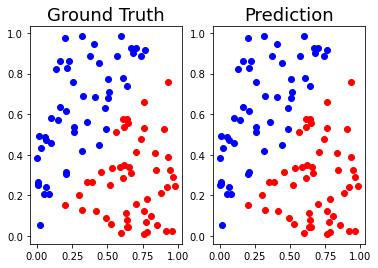

' FILL IN HERE '

In [56]:
""" Customize your own code if needed """

data, label = GenData.fetch_data('Linear', 100)

net = SimpleNet( lr = 3e-1) # 寫死的學習率
net.train(data, label)

pred_result = np.round(net.forward(data))
print(data.shape)
SimpleNet.plot_result(data, label, pred_result.T)

""" FILL IN HERE """

Epochs 0: 
test accuracy: 50.00%
Epochs 100: 
test accuracy: 50.00%
Epochs 200: 
test accuracy: 96.01%
Epochs 300: 
test accuracy: 99.95%
Epochs 400: 
test accuracy: 99.99%
Epochs 500: 
test accuracy: 99.99%
Epochs 600: 
test accuracy: 99.99%
Epochs 700: 
test accuracy: 100.00%
Epochs 800: 
test accuracy: 100.00%
Epochs 900: 
test accuracy: 100.00%
Epochs 1000: 
test accuracy: 100.00%
Epochs 1100: 
test accuracy: 100.00%
Epochs 1200: 
test accuracy: 100.00%
Epochs 1300: 
test accuracy: 100.00%
Epochs 1400: 
test accuracy: 100.00%
Epochs 1500: 
test accuracy: 100.00%
Epochs 1600: 
test accuracy: 100.00%
Epochs 1700: 
test accuracy: 100.00%
Epochs 1800: 
test accuracy: 100.00%
Epochs 1900: 
test accuracy: 100.00%
Training finished
test accuracy: 100.00%


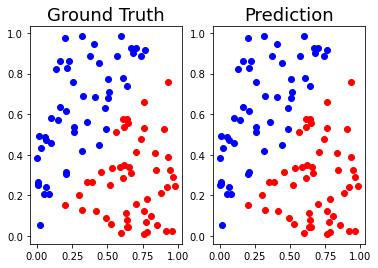

' FILL IN HERE '

In [57]:
""" Customize your own code if needed """

data, label = GenData.fetch_data('Linear', 100)

net = SimpleNet( lr = 2) # 讓學習率隨loss變化
net.train(data, label)

pred_result = np.round(net.forward(data))
SimpleNet.plot_result(data, label, pred_result.T)

""" FILL IN HERE """

### Run "XOR"

Epochs 0: 
test accuracy: 50.58%
Epochs 500: 
test accuracy: 97.83%
Epochs 1000: 
test accuracy: 98.28%
Epochs 1500: 
test accuracy: 98.41%
Epochs 2000: 
test accuracy: 98.39%
Epochs 2500: 
test accuracy: 97.69%
Epochs 3000: 
test accuracy: 99.08%
Epochs 3500: 
test accuracy: 99.87%
Epochs 4000: 
test accuracy: 99.96%
Epochs 4500: 
test accuracy: 99.97%
Epochs 5000: 
test accuracy: 99.98%
Epochs 5500: 
test accuracy: 99.98%
Epochs 6000: 
test accuracy: 99.99%
Epochs 6500: 
test accuracy: 99.99%
Epochs 7000: 
test accuracy: 99.99%
Epochs 7500: 
test accuracy: 99.99%
Epochs 8000: 
test accuracy: 99.99%
Epochs 8500: 
test accuracy: 99.99%
Epochs 9000: 
test accuracy: 99.99%
Epochs 9500: 
test accuracy: 99.99%
Training finished
test accuracy: 99.99%


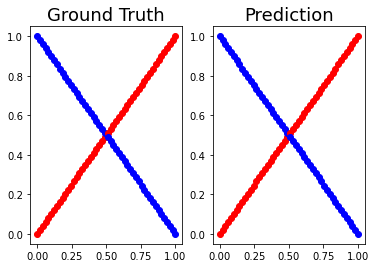

' FILL IN HERE '

In [58]:
""" Customize your own code if needed """

data, label = GenData.fetch_data('XOR', 100)

netXor = SimpleNet( num_step=10000, print_interval=500, lr = 2e-1)
netXor.train(data, label)

pred_result = np.round(netXor.forward(data))
SimpleNet.plot_result(data, label, pred_result.T)

""" FILL IN HERE """

Epochs 0: 
test accuracy: 51.57%
Epochs 500: 
test accuracy: 97.88%
Epochs 1000: 
test accuracy: 96.63%
Epochs 1500: 
test accuracy: 97.73%
Epochs 2000: 
test accuracy: 98.67%
Epochs 2500: 
test accuracy: 98.89%
Epochs 3000: 
test accuracy: 99.95%
Epochs 3500: 
test accuracy: 99.98%
Epochs 4000: 
test accuracy: 99.99%
Epochs 4500: 
test accuracy: 99.99%
Epochs 5000: 
test accuracy: 99.99%
Epochs 5500: 
test accuracy: 99.99%
Epochs 6000: 
test accuracy: 99.99%
Epochs 6500: 
test accuracy: 99.99%
Epochs 7000: 
test accuracy: 100.00%
Epochs 7500: 
test accuracy: 100.00%
Epochs 8000: 
test accuracy: 100.00%
Epochs 8500: 
test accuracy: 100.00%
Epochs 9000: 
test accuracy: 100.00%
Epochs 9500: 
test accuracy: 100.00%
Training finished
test accuracy: 100.00%


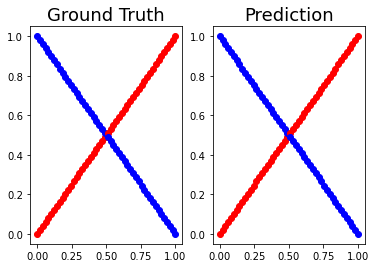

' FILL IN HERE '

In [59]:
""" Customize your own code if needed """

data, label = GenData.fetch_data('XOR', 100)

netXor = SimpleNet( num_step=10000, print_interval=500, lr = 5e-1)
netXor.train(data, label)

pred_result = np.round(netXor.forward(data))
SimpleNet.plot_result(data, label, pred_result.T)

""" FILL IN HERE """